# Задание №2 
# Практикума на ЭВМ 317 группы
## Никишин Евгений Сергеевич
## Дата сдачи: 27.10.2015

Загружаем необходимые библиотеки

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import time
np.random.seed(317)
%matplotlib inline

# Первая часть

### 1) Загружаем датасет

In [2]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')

### 2) Разбиваем на тренировочную и тестовую выборки

#### Сначала следует перемешать

In [4]:
shuffled = np.arange(mnist.data.shape[0])
np.random.shuffle(shuffled)

In [5]:
data_train = mnist.data[shuffled[:60000]]
target_train = mnist.target[shuffled[:60000]]
data_test = mnist.data[shuffled[60000:]]
target_test = mnist.target[shuffled[60000:]]

### 3) Визуализируем 5 случайных объектов из каждого из 10 классов

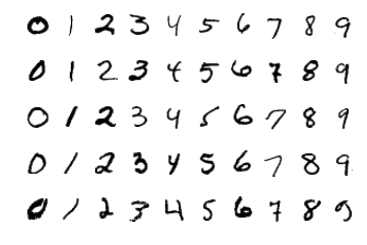

In [5]:
classes_count = np.unique(target_train).shape[0]
for cl in range(classes_count):
    current_class = np.where(target_train == cl)
    for iteration in range(0, 5):
        idx = np.random.randint(0, current_class[0].shape[0])
        res_img = np.reshape(data_train[current_class[0][idx]], newshape=(28, 28))
        plt.subplot(5, classes_count, cl + iteration * classes_count + 1)
        plt.imshow(res_img, cmap="Greys")
        plt.axis("off")

### 4) Исследование алгоритмов поиска ближайших соседей

#### Выбираем признаки

In [6]:
features10 = np.random.randint(0, data_test.shape[1], 10)
features20 = np.random.randint(0, data_test.shape[1], 20)
features100 = np.random.randint(0, data_test.shape[1], 100)
features_list = [features10, features20, features100]

#### Собственная реализация
##### Примечание: мой ноутбук так и не смог запустить собственную реализацию и brute для блоков размера больше 20. Справедливо будет заметить, что kd_tree и ball_tree отлично работают для блоков размера 1000

In [23]:
from task7 import object_dist1
def my_neighbors(X_train, X_test):
    res = np.argsort(object_dist1(X_train.astype('float64'), X_test.astype('float64')), axis=0)
    return res.T[:, :5]

#### Исследуем собственную реализацию

In [26]:
n_blocks = 500
size = data_test.shape[0] // n_blocks
for features in features_list:
    start = time.clock()
    results = np.zeros((data_test.shape[0], 5), dtype='int64')
    for block in range(n_blocks):
        results[block * size:(block + 1) * size, :] = my_neighbors(
            data_train[:, features], data_test[block * size:(block + 1) * size, features])
    print('my realisation time with', features.shape[0], 'features =', round(time.clock() - start, 2), 'seconds')

my realisation time with 10 features = 89.89 seconds
my realisation time with 20 features = 131.08 seconds
my realisation time with 100 features = 429.96 seconds


#### Исследуем готовые реализации

In [17]:
algorithms = ['brute', 'kd_tree', 'ball_tree']
n_blocks = 500
size = data_test.shape[0] // n_blocks
for algorithm in algorithms:
    for features in features_list:
        nn = NearestNeighbors(algorithm=algorithm)
        nn.fit(data_train[:, features])
        start = time.clock()
        results = np.zeros((data_test.shape[0], 5), dtype='int64')
        for block in range(n_blocks):
            results[block * size:(block + 1) * size, :] = nn.kneighbors(
                data_test[block * size:(block + 1) * size, features], 5, False)
        print(algorithm, 'time with', features.shape[0], 'features =', round(time.clock() - start, 2), 'seconds')

brute time with 10 features = 18.55 seconds
brute time with 20 features = 28.19 seconds
brute time with 100 features = 150.37 seconds
kd_tree time with 10 features = 1.75 seconds
kd_tree time with 20 features = 3.93 seconds
kd_tree time with 100 features = 101.87 seconds
ball_tree time with 10 features = 6.77 seconds
ball_tree time with 20 features = 25.92 seconds
ball_tree time with 100 features = 110.51 seconds


### Выводы: для небольшого количества признаков следует выбирать kd_tree, однако уже при 100 признаках особой разницы между kd_tree и ball_tree нет. Во всех случаях им обоим проигрывает brute, а хуже всех трех работает пользовательская реализация, очевидно, из-за недостаточно эффективного подсчета попарных расстояний. Однако kd_tree и ball_tree не поддерживают косинусную метрику, которая очень пригодится для классификации текстов

### 5) KFold

In [3]:
def KFold(n, n_folds=5):
    res = []
    indices = np.arange(n)
    
    size_ext = n // n_folds + 1
    residue = n % n_folds
    for i in range(residue):
        fold = indices[i * size_ext:(i + 1) * size_ext]
        res.append(tuple((fold, np.setdiff1d(indices, fold))))
    
    size = n // n_folds
    for i in range(n_folds - residue):
        fold = indices[residue * size_ext + i * size:residue * size_ext + (i + 1) * size]
        res.append(tuple((fold, np.setdiff1d(indices, fold))))
    return res

### 6) Реализация оценки точности метода kNN

#### Возвращает tuple из списка прогнозов (для каждого k) и списка точностей (тоже для каждого k)

In [8]:
def my_kNN(X_train, X_test, y_train, y_test, k_list, metric='euclidean', n_blocks=1):
    accuracy = np.zeros(k_list.shape)
    predicts = []
    for k in range(k_list.shape[0]):
        nn = NearestNeighbors(n_neighbors=k_list[k], algorithm='brute', metric=metric)
        nn.fit(X_train)
        nearest = np.zeros((X_test.shape[0], k_list[k]), dtype='int64')
        size = X_test.shape[0] // n_blocks
        for block in range(n_blocks):
            nearest[block * size:(block + 1) * size, :] = nn.kneighbors(
                X_test[block * size:(block + 1) * size, :], k_list[k], False)
        '''
        Поэтапно:
        op1 = nearest
        op2 = y_train[op1].astype('int64')
        op3 = sp.stats.mode(op2, axis=1)
        op4 = op3[0].astype('float64')
        op5 = np.isclose(op4.ravel(), y_test)
        op6 = np.sum(op5)
        accuracy[k] = op6
        '''
        predicts.append(sp.stats.mode(y_train[nearest].astype('int64'), axis=1)[0].astype('float64').ravel())
        accuracy[k] = np.sum(np.isclose(predicts[k], y_test))
        accuracy[k] /= X_test.shape[0]
    return predicts, accuracy

#### Попробуем

In [70]:
start = time.clock()
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_train[:2000], target_train[:2000], test_size=0.2)
acc = (my_kNN(X_train, X_test, y_train, y_test, np.array([2, 5]), 'euclidean'))[1]
print(acc)
print('worked', round(time.clock() - start, 2), 'seconds')

[ 0.87    0.8975]
worked 1.03 seconds


### 7) Оценим точность по кросс-валидации с 3-мя фолдами для k от 1 до 10 и для евклидовой и косинусной меры

#### Параметры

In [6]:
k_list = np.arange(1, 11).astype('int64')
metrics = ['euclidean', 'cosine']
kf = KFold(data_train.shape[0], n_folds=3)
n_blocks = 500

#### Подсчет

In [11]:
for metric in metrics:
    start = time.clock()
    accuracy = np.zeros(k_list.shape)
    for test, train in kf:
        accuracy += (my_kNN(data_train[train, :], data_train[test, :], 
                          target_train[train], target_train[test], k_list, metric, n_blocks))[1]
    accuracy /= 3
    print(metric, 'metric worked', round(time.clock() - start, 2), 'seconds with accuracies', 
          np.around(accuracy, decimals=3))
    print('best k is', np.argmax(accuracy) + 1)

euclidean metric worked 20108.82 seconds with accuracies [ 0.969  0.962  0.969  0.967  0.968  0.967  0.967  0.965  0.965  0.964]
best k is 3
cosine metric worked 21499.0 seconds with accuracies [ 0.973  0.969  0.973  0.973  0.973  0.972  0.971  0.971  0.97   0.97 ]
best k is 3


### Выводы: 

### 8) Взвешенный kNN
#### Описание: сначала создаем матрицу из дистанций для k ближайших к объекту, затем берем аргмаксимум взвешенных голосов для каждого тестового объекта
##### Примечание: векторно реализовать взвешенный вариант не удалось

In [1]:
def my_weighted_kNN(X_train, X_test, y_train, y_test, k_list, metric='euclidean', n_blocks=1):
    epsilon = 0.01
    accuracy = np.zeros(k_list.shape)
    predicts = []
    for k in range(k_list.shape[0]):
        nn = NearestNeighbors(n_neighbors=k_list[k], algorithm='brute', metric=metric)
        nn.fit(X_train)
        nearest = np.zeros((X_test.shape[0], k_list[k]), dtype='int64')
        distances = np.zeros((X_test.shape[0], k_list[k]))
        size = X_test.shape[0] // n_blocks
        for block in range(n_blocks):
            distances[block * size:(block + 1) * size, :], nearest[block * size:(block + 1) * size, :] = nn.kneighbors(
                X_test[block * size:(block + 1) * size, :], k_list[k], True)
        #distances, nearest = nn.kneighbors(X_test, k_list[k], True)
        
        weights = 1 / (distances + epsilon)
        classes = np.unique(y_train)
        votes = np.zeros(classes.shape)
        answers = y_train[nearest]
        current_predict = np.zeros(y_test.shape)
        
        for test in range(X_test.shape[0]):
            for cl in range(classes.shape[0]):
                idx = np.where(answers[test, :] == classes[cl])
                votes[cl] = np.sum(weights[test, idx[0]])
            
            current_predict[test] = classes[np.argmax(votes)]
            accuracy[k] += np.isclose(current_predict[test], y_test[test])
        predicts.append(current_predict)
        accuracy[k] /= X_test.shape[0]
    return predicts, accuracy

#### Попробуем

In [10]:
start = time.clock()
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_train[:2000], target_train[:2000], test_size=0.2)
acc = (my_weighted_kNN(X_train, X_test, y_train, y_test, np.array([5]), 'euclidean', 20))[1]
print(acc)
print('worked', round(time.clock() - start, 2), 'seconds')

[ 0.9075]
worked 0.72 seconds


#### Исследование для евклидовой метрики

In [12]:
metrics = ['euclidean']
for metric in metrics:
    start = time.clock()
    accuracy = np.zeros(k_list.shape)
    for test, train in kf:
        accuracy += (my_weighted_kNN(data_train[train, :], data_train[test, :], 
                          target_train[train], target_train[test], k_list, metric, n_blocks))[1]
    accuracy /= 3
    print(metric, 'metric worked', round(time.clock() - start, 2), 'seconds with accuracies', 
          np.around(accuracy, decimals=3))
    print('best k is', np.argmax(accuracy) + 1)

euclidean metric worked 19649.39 seconds with accuracies [ 0.969  0.969  0.971  0.971  0.969  0.97   0.968  0.968  0.966  0.967]
best k is 4


#### Исследование для косинусной метрики

In [11]:
metrics = ['cosine']
for metric in metrics:
    start = time.clock()
    accuracy = np.zeros(k_list.shape)
    for test, train in kf:
        accuracy += (my_weighted_kNN(data_train[train, :], data_train[test, :], 
                          target_train[train], target_train[test], k_list, metric, n_blocks))[1]
    accuracy /= 3
    print(metric, 'metric worked', round((time.clock() - start) / 3600, 2), 'hours with accuracies', 
          np.around(accuracy, decimals=3))
    print('best k is', np.argmax(accuracy) + 1)

cosine metric worked 5.94 hours with accuracies [ 0.973  0.973  0.974  0.975  0.974  0.974  0.972  0.972  0.971  0.971]
best k is 4


##### Примечание: 5.94 часа это примерно 21384 секунды, надо было с самого начала все в часах считать

### Вывод: взвешенный чуточку лучше, что и ожидалось, так как это чуть более "умный алгоритм" и интуитивно кажется хорошей идеей считать более важным объект, расстояние до которого меньше

### 9) Оценим на тестовой выборке

#### Для начала, ради интереса, взглянем на  евклидову метрику

In [12]:
start = time.time()
predict_tmp, accuracy_tmp = my_weighted_kNN(data_train, data_test, target_train, target_test, 
                                            k_list=np.array([3]), metric='euclidean', n_blocks=500)
print('worked', round((time.time() - start) / 60, 2), 'minutes with accuracy', np.around(accuracy_tmp, 3)[0])

worked 8.69 minutes with accuracy 0.97


#### Лучший алгоритм

In [13]:
start = time.time()
predict, accuracy = my_weighted_kNN(data_train, data_test, target_train, target_test, 
                                    k_list=np.array([4]), metric='cosine', n_blocks=500)
print('worked', round((time.time() - start) / 60, 2), 'minutes with accuracy', np.around(accuracy, 4)[0])
predict = predict[0]

worked 10.62 minutes with accuracy 0.9755


### В целом, очень даже неплохо. Лучшая в мире точность, которой удалось достигнуть на mnist'е -- 99.79% с помощью нейронных сетей. Однако, если тонко настроить kNN, то можно добиться точности 99.37%
#### Ссылочки: [один](http://yann.lecun.com/exdb/mnist/ "про kNN"), [два](http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html "про нейронки")

### 10) Анализ ошибок

#### Посмотрим на ошибочно классифицированные объекты

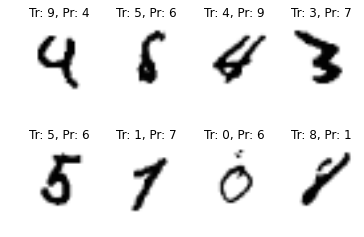

In [26]:
count = 8
mistakes = np.where(target_test.astype('int64') != predict.astype('int64'))[0]
some_indices = np.random.randint(0, mistakes.shape[0], size=count)
for i in range(count):
    ind = mistakes[some_indices[i]]
    res_img = np.reshape(data_test[ind], newshape=(28, 28))
    plt.subplot(2, 4, i + 1)
    plt.title('Tr: %(true)i, Pr: %(predict)i' % {'true': target_test[ind].astype('int64').astype(int), 
                                                 'predict': predict[ind].astype('int64').astype(int)})
    plt.imshow(res_img, cmap="Greys")
    plt.axis("off")

### Общие черты: либо неразборчиво написано, либо написано очень похоже на другую цифру

#### Построим матрицу ошибок

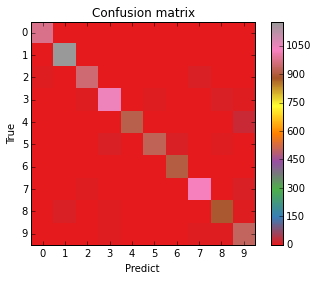

In [37]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(target_test.astype('int64'), predict.astype('int64'))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Set1)
plt.colorbar()
plt.title('Confusion matrix')
tick_marks = np.arange(np.unique(mnist.target).shape[0])
plt.xticks(tick_marks, np.unique(mnist.target.astype('int64')))
plt.yticks(tick_marks, np.unique(mnist.target.astype('int64')))
plt.ylabel('True')
plt.xlabel('Predict')

### Судя по построенной матрице, почти идеальная классификация (пришлось сделать такую тему, чтобы хоть как-то было заметно неправильные классификации)
### Если поломать глаза, то можно заметить, что классификатор часто принимает 4 за 9, что достаточно естественно. Также часто путаются 3 и 8 (тоже естественно)

# Вторая часть

### 11) Загружаем датасет 20 newsgroups

In [5]:
from sklearn.datasets import fetch_20newsgroups
newsgroups = fetch_20newsgroups(remove=('headers', 'footers', 'quotes'))

### 12) Переводим в нижний регистр и удаляем небуквы и нецифры

In [6]:
import re
processed_text = []
pattern = re.compile('[\W_]+')

for text in newsgroups.data:
    text = pattern.sub(' ', text.lower())
    processed_text.append(text)

### 13) Разбиваем на термы

In [7]:
for text in range(len(processed_text)):
    processed_text[text] = processed_text[text].split()

### 14) Преобразуем в sparse-матрицу

In [8]:
indptr = [0]
indices = []
data = []
vocabulary = {}
for doc in processed_text:
    for term in doc:
        index = vocabulary.setdefault(term, len(vocabulary))
        indices.append(index)
        data.append(1)
    indptr.append(len(indices))
N = len(vocabulary)
data_sparse = sp.sparse.csr_matrix((data, indices, indptr), shape=(len(processed_text), N), dtype=int)

### 15) Преобразуем с помощью TF-IDF

In [9]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf = TfidfTransformer()
tfidf.fit(data_sparse)
data_tfidf = tfidf.transform(data_sparse)

### 16) Исследование

#### Параметры

In [10]:
k_list = np.arange(1, 11).astype('int64')
metrics = ['euclidean', 'cosine']
kf = KFold(data_tfidf.shape[0], n_folds=3)
target_train = newsgroups.target

#### Подсчет для невзвешенного

In [20]:
for data in range(2):
    if data == 0:
        data_train = data_sparse
        print("Sparse:")
    else:
        data_train = data_tfidf
        print("TF-IDF:")
    for metric in metrics:
        start = time.clock()
        accuracy = np.zeros(k_list.shape)
        for test, train in kf:
            accuracy += (my_kNN(data_train[train, :], data_train[test, :], 
                              target_train[train], target_train[test], k_list, metric))[1]
        accuracy /= 3
        print(metric, 'metric worked', round(time.clock() - start, 2), 'seconds with accuracies', 
              np.around(accuracy, decimals=3))
        print('best k is', np.argmax(accuracy) + 1)
    print()

Sparse:
euclidean metric worked 61.04 seconds with accuracies [ 0.21   0.187  0.182  0.187  0.19   0.191  0.193  0.196  0.2    0.201]
best k is 1
cosine metric worked 57.74 seconds with accuracies [ 0.282  0.267  0.266  0.259  0.255  0.253  0.253  0.255  0.252  0.253]
best k is 1

TF-IDF:
euclidean metric worked 56.08 seconds with accuracies [ 0.137  0.083  0.077  0.09   0.089  0.086  0.083  0.08   0.08   0.08 ]
best k is 1
cosine metric worked 53.6 seconds with accuracies [ 0.616  0.571  0.588  0.597  0.608  0.611  0.614  0.614  0.617  0.615]
best k is 9



#### Подсчет для взвешенного

In [98]:
for data in range(2):
    if data == 0:
        data_train = data_sparse
        print("Sparse:")
    else:
        data_train = data_tfidf
        print("TF-IDF:")
    for metric in metrics:
        start = time.clock()
        accuracy = np.zeros(k_list.shape)
        for test, train in kf:
            accuracy += (my_weighted_kNN(data_train[train, :], data_train[test, :], 
                              target_train[train], target_train[test], k_list, metric))[1]
        accuracy /= 3
        print(metric, 'metric worked', round(time.clock() - start, 2), 'seconds with accuracies', 
              np.around(accuracy, decimals=3))
        print('best k is', np.argmax(accuracy) + 1)
    print()

Sparse:
euclidean metric worked 94.01 seconds with accuracies [ 0.21   0.212  0.212  0.214  0.218  0.216  0.213  0.215  0.219  0.218]
best k is 9
cosine metric worked 91.06 seconds with accuracies [ 0.282  0.282  0.281  0.28   0.277  0.272  0.271  0.268  0.266  0.266]
best k is 1

TF-IDF:
euclidean metric worked 90.46 seconds with accuracies [ 0.137  0.137  0.103  0.127  0.122  0.114  0.108  0.104  0.103  0.102]
best k is 2
cosine metric worked 86.9 seconds with accuracies [ 0.616  0.616  0.627  0.632  0.634  0.634  0.635  0.635  0.634  0.634]
best k is 8



### Вывод: лучшей совокупностью для данной задачи является косинусная метрика + преобразование TF-IDF, работает и быстрее, и точнее. При этом использование взвешенного kNN (при k = 8, оптимальный) по сравнению с невзвешенным (при k = 9, оптимальный) работает лучше примерно на 2%

### 17) Оценим на тестовой выборке

#### Все предобработки

In [11]:
news_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'))

In [12]:
target_test = news_test.target

In [13]:
import re
processed_text = []
pattern = re.compile('[\W_]+')

for text in news_test.data:
    text = pattern.sub(' ', text.lower())
    processed_text.append(text)

In [14]:
for text in range(len(processed_text)):
    processed_text[text] = processed_text[text].split()

#### Словарь должен оставаться таким же!

In [15]:
indptr = [0]
indices = []
data = []
for doc in processed_text:
    for term in doc:
        if term in vocabulary:
            index = vocabulary[term]
        indices.append(index)
        data.append(1)
    indptr.append(len(indices))
    
data_sparse_test = sp.sparse.csr_matrix((data, indices, indptr), shape=(len(processed_text), N), dtype=int)

In [16]:
data_test = tfidf.transform(data_sparse_test)

#### Интереса ради глянем, какой будет точность у невзвешенного при k = 9

In [61]:
start = time.clock()
predict, accuracy = my_kNN(data_tfidf, data_test, target_train, target_test, k_list = np.array([9]), metric='cosine')
print('worked', round(time.clock() - start, 2), 'seconds with accuracy', np.around(accuracy, decimals=3))

worked 5.87 seconds with accuracy [ 0.554]


#### Наконец, подсчет для лучшего алгоритма

In [57]:
start = time.clock()
predict, accuracy = my_weighted_kNN(data_tfidf, data_test, target_train, target_test, 
                                    k_list = np.array([8]), metric='cosine')
predict = predict[0].astype('int64')
print('worked', round(time.clock() - start, 2), 'seconds with accuracy', np.around(accuracy, decimals=3)[0])

worked 8.05 seconds with accuracy 0.559


### Вывод: точность классификации отличается на тестовой выборке от точности на кросс-валидации на целых 7.6%, что достаточно много. Отчасти это связано с тем, что не все слова из тестовой выборки присутствуют в словаре.

### 18) Посмотрим на ошибочно классифицированные документы и построим матрицу ошибок

#### Какие вообще есть категории

In [27]:
newsgroups.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

#### Посмотрим на 7 случайных неправильно классифицированных текстов

In [28]:
count = 7
mistakes = np.where(target_test != predict)[0]
some_indices = np.random.randint(0, mistakes.shape[0], size = count)
for i in range(count):
    ind = mistakes[some_indices[i]]
    print('-------------------------------------------------------------------------')
    print('True label:', newsgroups.target_names[target_test[ind]])
    print('Predicted label:', newsgroups.target_names[predict[ind]])
    print(np.array(newsgroups.data)[ind])
    print('-------------------------------------------------------------------------')

-------------------------------------------------------------------------
True label: talk.religion.misc
Predicted label: rec.sport.hockey
FOR SALE !!!

      DECpc 325sxLP

   It's in very good condition, used for one year. It has

      - 25 Mhz Intel 386
      - 52 MB Hard Disk
      - Super Color VGA Monitor
      - 2-button mouse
      - 1.44 MG floppy disk drive

      Software:
    ------------

       - Microsoft Dos 5.0
       - Microsoft Windows 3.1
       - Microsoft Works for Windows 2.0
       - Borland Turbo Pascal 6.0
       - Borland Turbo C++ 3.0 for Dos
       
-------------------------------------------------------------------------
-------------------------------------------------------------------------
True label: comp.graphics
Predicted label: comp.windows.x

No, but some OS's ( COHERENT , etc ) are able to drive one of the ports in
polled mode without using the IRQ. In your example, after accessing the
modem, the mouse won't work until you reboot, because the IR

### Можно сделать следующие выводы:
1. Существуют неправильно размеченные тексты (первый пример, содержащий характеристики компьютера, явно не относится с теме религии)
2. Некоторые темы очень похожи (вроде comp.sys.ibm.pc.hardware и comp.graphics). Возможно, имеет смысл их объединить.
3. Некоторые сообщения очень короткие, вследствие чего иногда классификатору не удается определить правильно тему.
4. Частые ошибки происходят на "разном" (.misc), поскольку в таких темах весьма большой разброс. Возможно, следует сделать классификатор, который относит к "разному" не в случае уверенности в этой категории, а в случае, когда уверенность во всех других примерно одинаковая. Это как вариант

#### Построим матрицу ошибок

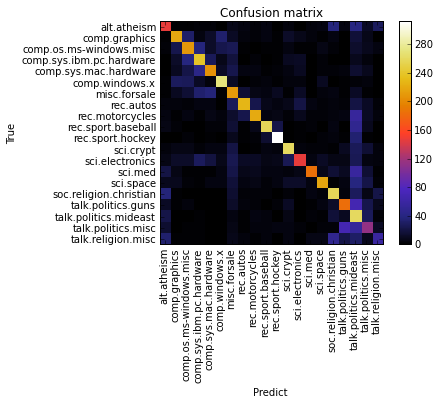

In [56]:
from sklearn.metrics import confusion_matrix
%matplotlib inline
cm = confusion_matrix(target_test, predict)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.CMRmap)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(newsgroups.target_names))
plt.xticks(tick_marks, newsgroups.target_names, rotation=90)
plt.yticks(tick_marks, newsgroups.target_names)
plt.ylabel('True')
plt.xlabel('Predict')

### Выводы: 
1. Cразу бросается в глаза, что классификатор часто ошибочно предсказывает тему talk.politics.mideast. 
2. Как и было сказано выше, хуже всего классификатор работает с темами .misc. Это связано с тем, что эти группы слишком неопределенные. 
3. Также видна определенная размытость в области компьютеров, потому что тексты на эти темы достаточно похожие.
4. Возможные пути решения проблем: сделать темы более "разделимыми", для этого можно некоторые из них объединить, или же, для того, чтобы различать схожие темы, можно увеличить выборку.

## 19) Глобальные выводы. 
1. В предложенных задачах косинусная метрика справляется лучше. Однако за это приходится платить несовместимостью с ball-tree и kd-tree, и, кроме того, косинусная матрика работает дольше на классификации картинок. 
2. Взвешенное голосование тоже показало себя лучше(точнее). На текстах оно работало дольше, однако разница в 50 и 80 секунд не особо ощутима, а на картинках даже немного быстрее работает.
3. kNN прекрасно справился с задачей классификации на mnist'e, а вот на текстах точность оставляет желать лучшего.
4. Выбор k влияет на точность, но не очень сильно, хотя интуитивно кажется, что не так. Возможно, выбор k критичен 1на малых размерностях
5. TF-IDF очень хорошо помогает при работе с текстами.
6. Зачастую алгоритмы совершают такие же ошибки, как и человек (на mnist'e человек бы тоже некоторые цифры неправильно классифицировал).